# 6 ゲート付きRNN

## 6.1 RNNの問題点

前章のRNNは時系列データの長期の依存関係を学習することが苦手。
その理由は、BPTT（Backpropagation Through Time)において勾配消失もしくは勾配爆発が起こることに原因がある。

### 6.1.1 RNNの復習

![6-1](images/6-1.png)

図6-1のように、RNNレイヤは時系列データである$ x_t $ を入力すると、 $ h_t $ を出力する。この $h_t$ は、RNNレイヤの隠れ状態とも呼ばれ、その状態に過去からの情報が記録される。

![6-2](images/6-2.png)

図6-2はRNNレイヤの順伝播で行う計算。

### 6.1.2 勾配消失もしくは勾配爆発

RNNLM(RNNの言語モデル)の問題点を指摘するにあたり、次の6-3 で示すタスクをもう１度考えてみる。

*6-3*
```
Tom was watching TV in his room. Mary came into the room. Mary said hi to ??
```

上の問題例をRNNLMが学習する立場になって考える。ここでは正解ラベル「Tom」という単語が与えられたとき、RNNLMの中で勾配がどのように伝播するかを見る。ここではBPTTで学習を行う。そのため正解ラベルが「Tom」だと与えられた場所から、過去の方向に向かって勾配を伝えることになる。

![6-4](images/6-4.png)

図6-4で示すように、正解ラベルが「Tom」であることを学習する際に重要になるのが、RNNレイヤの存在。RNNレイヤが過去方向に「意味のある勾配」を伝達することによって、時間方向の依存関係を学習することができる。このとき勾配には学習すべき意味のある情報がはいっていて、それを過去に向かって伝えることで長期の依存関係を学習する。

残念ながら、現在のシンプルなRNNレイヤでは、時間をさかのぼるに従って勾配が小さくなる（勾配消失）もしくは大きくなる（勾配爆発）のどちらかの運命をたどることがほとんどで、長期の依存関係を学習することができない。

### 6.1.3 勾配消失もしくは勾配爆発の原因

図6-5は、RNNレイヤの時間方向だけの勾配の伝播だけに着目する。

![6-5](images/6-5.png)

図6-5に示すように、時間方向の勾配に着目すると、逆伝播によって伝わる勾配は「tanh」と「＋」と「MatMul（行列の積）」の演算。

「＋」の逆伝播は、上流から伝わる勾配をそのまま下流へ流すだけで、勾配の値は変わらない。残りの２つの演算「tanh」と「MatMul」が問題。

まずは「tanh」について。 $ y=\tanh(x) $ のときに、微分は $\frac{\partial y}{\partial x}= 1 - y^2 $になる（詳細は付録A参照）。このとき、 $ y=\tanh(x)$の値とその微分の値をそれぞれグラフにプロットすると、図6-6のようになる。

![6-6](images/6-6.png)

見ての通り、その値は1.0以下となり、xが0から遠ざかるにつれてその値は小さくなる。これが意味することは、逆伝搬において勾配が $\tanh$ ノードを通るたびに、その値はどんどん小さくなっていくということ。


続いて、MatMulノードに着目する。ここでは話を単純にするため、tanhノードを無視することにする。そうすると、RNNレイヤの逆伝播の勾配は、図6-7のように「MatMul」の演算によってのみ変化する。

![6-7](images/6-7.png)

このとき、MatMulノードの逆伝播は、$ \mathrm{d}hW^T_h $ による行列の積によって勾配が計算される。この行列の積の計算では、毎回同じ重みである $W_h$が使われていて、勾配の大きさは指数的に増加もしくは減少する。

指数的に増加するか、減少するかは、行列の「特異値」が指標になる。行列の特異値は、簡単にいえば、データにどれだけ広がりがあるかを表す。この特異値の値が、より正確には、複数ある特異値の中でその最大値が１より大きいかどうかで、勾配の大きさの変化を予測することができる。

（特異値の最大値が１より大きい場合は指数的に増加する可能性が高いと予測できる。一方、特異値が１より小さい場合には指数的に減少すると判断できる。ここで、特異値が１より大きいときは必ず勾配爆発になるとは限らない。つまりこれは必要条件であって十分条件とはいえない。）

ここでは、勾配爆発の回避策から見ていく。
勾配爆発への対策には定番の手法がある。それは勾配クリッピング（gradients clipping)と呼ばれる手法。アルゴリズムは擬似コードで書くと次のようになる。


$$
  \mathrm{if}\ \|\hat{g}\| \geq threshold \ : \\
   \hat{g} = \frac{threshold}{\| \hat{g} \|} \hat{g}
$$

ここでは、ニューラルネットワークで使われるすべてのパラメータに対する勾配をひとつにまとめていることを想定して、これを $ \hat{g}$ という記号で表している。

（例えば、あるモデルには重み $W1$と$W2$の２つがパラメータとしてあったとき、その２つのパラメータに対する勾配 $\mathrm{d}W1$ と $\mathrm{d}W2$を結合したものを $\hat{g}$としている。）

これをpythonで実装すると下記のようになる。

In [1]:
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate　　　
clip_grads(grads, max_norm)

SyntaxError: invalid character in identifier (<ipython-input-1-29dda7148385>, line 17)

## 6.2 勾配消失とLSTM

勾配消失を解決するには、RNNレイヤのアーキテクチャを根本から変える必要がある。ここで登場するのがゲート付きRNN。
ゲート付きRNNには多くのアーキテクチャ（ネットワーク構成）が提案されていて、その代表格にLSTMとGRUがある。本節ではLSTMにフォーカスして、その仕組をみていく。


### 6.2.1 LSTMのインタフェース

![6-11](images/6-11.png)

図6-11に示すように、RNNとLSTMレイヤのインタフェースの違いは、LSTMにはcという経路があること。このcは記憶セルと呼ばれ、LSTM専用の記憶部に相当する。

記憶セルの特徴は、それが自分自身だけで（LSTMレイヤ内だけで）データの受け渡しをするということ。つまり、LSTMレイヤ内だけで完結し、他のレイヤへ出力しない。


### 6.2.2 LSTMレイヤの組み立て

ここではLSTMのパーツをひとつずつ組み立てながら、その仕組をみていく。

LSTMには記憶セル $c_t$ がある。この $c_t$には、時刻tにおけるLSTMの記憶が格納されていて、これに過去から時刻tまでにおいて必要な情報がすべて格納されていると考えられる（もしくは、そうなるように学習を行う）。そして、その必要な情報が詰まった記憶を元に、外部のレイヤへ（そして次時刻のLSTMへ）隠れ状態 $h_t$ を出力する。このとき行う計算は、図6-12に示すように、記憶セルを$\tanh$関数によって変換したものを出力する。

![6-12](images/6-12.png)

図6-12で示すように、現在の記憶セル $c_t$ は、３つの入力（$c_{t-1}$、$h_{t-1}$、$x_t$）から「何らかの計算」によって求められるとする。ここでのポイントは、更新された$c_t$を使って、隠れ状態の$h_t$が計算されるということ。

次に、ゲートにいう機能について簡単に説明する。ゲートはデータの流れをコントロールする。

![6-14](images/6-14.png)

図6-14で示すように、ゲートの開き具合は0.0〜1.0までの実装で表せる。そしてその数値によって、次へ流す量をコントロールする。ここで大切なのは、「どれだけゲートを開くか」ということも、データから（自動的に）学ばせるということ。

（ゲートの開きぐらいを求めるにあたっては、sigmoid 関数を使用する。（sigmoidの出力は0.0〜0.1））


### 6.2.3 outputゲート

ここで、$\tanh(c_t)$に対してゲートを適用する。つまり、$\tanh(c_t)$の各要素に対して、「それらが次時刻の隠れ状態としてどれだけ重要か」ということを調整する。このゲートは、次の隠れ状態$h_t$の出力を司るゲートであることからoutputゲートと呼ばれる。

outputゲートの開き具合は、入力$x_t$と前の状態$h_{t-1}$から求める。このとき行う計算は次のようになる。なお、ここで使用する重みパラメータやバイアスの上添字には、outputの頭文字であるoを追加する。（以降も同じ）

*(6.1)*
$$
  o = \sigma (x_t W^{(o)}_x + h_{t-1} W^{(o)}_h + b^{(o)}
$$

このoと$\tanh(c_t)$の要素ごとの積を$h_t$として出力する。

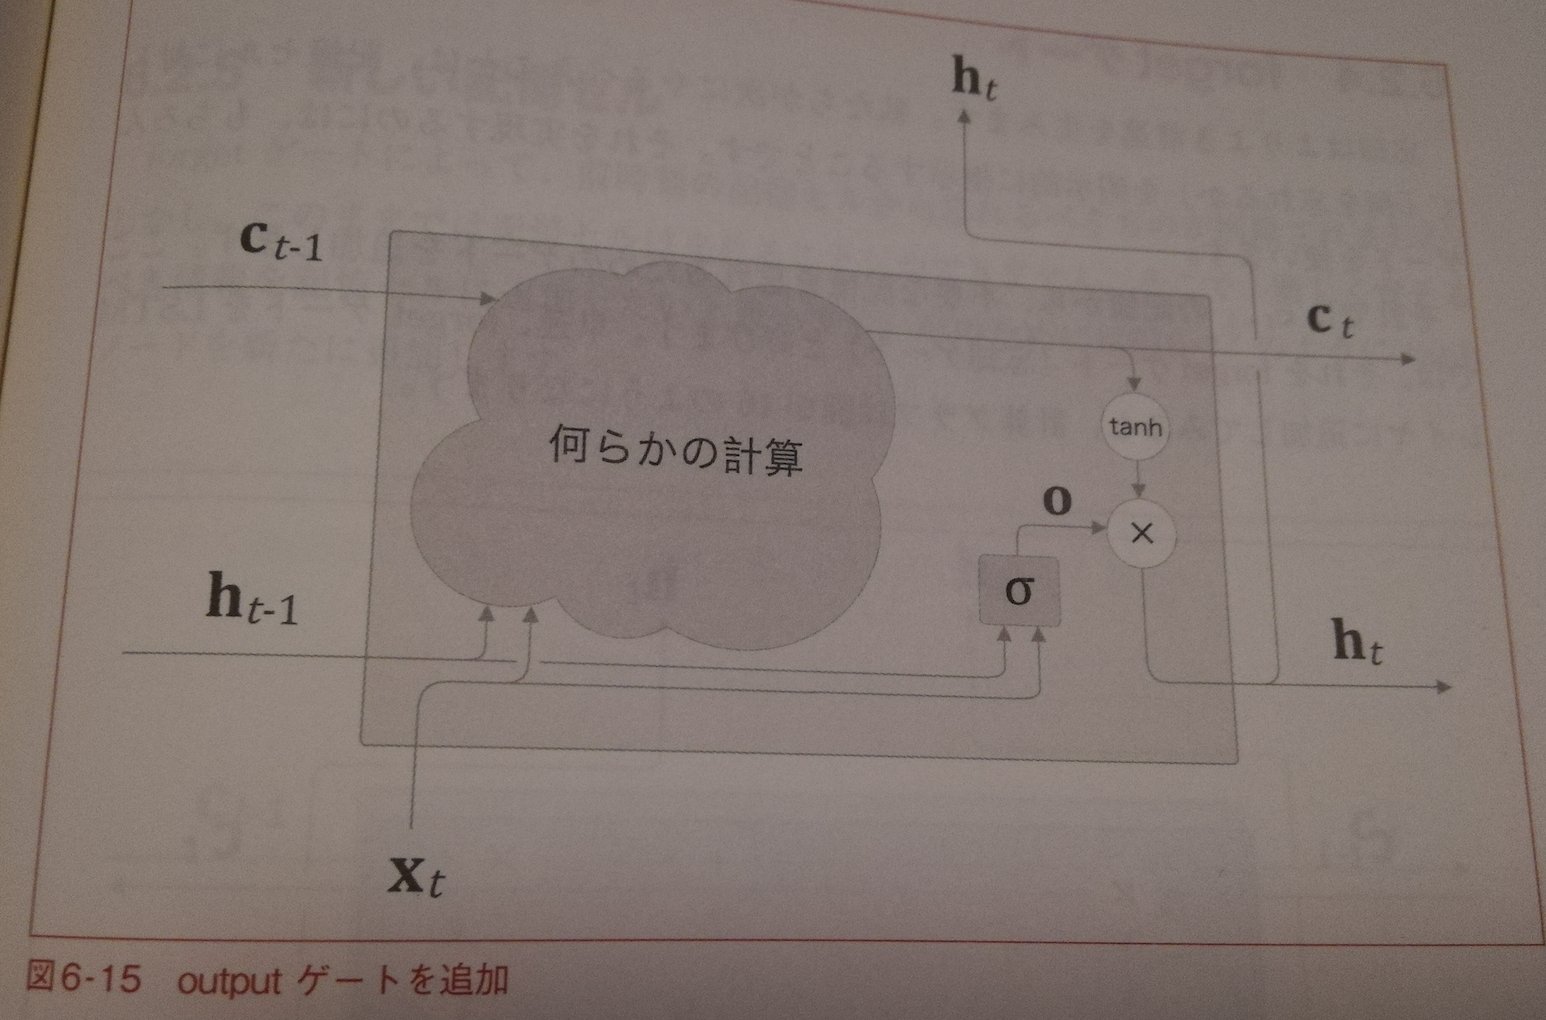

図6-15に示すように、outputゲートで行う式(6.1)の計算を$\sigma$で表すこといする。そして、その出力をoとすると、$h_t$はoと$\tanh(c_t)$の積によって計算される。なお、ここでいう「積」とは要素ごとの積であり、これはアダマール積とも呼ばれる。アダマール積を$\odot$で表すと、計算は次のようになる。

*(6.2)*
$$
  h_t = o \odot \tanh (c_t)
$$

以上がLSTMのoutputゲート。

### 6.2.4 forgetゲート

記憶セルに対して「何を忘れるか」を明示的に指示する。forgetゲートと呼ぶ。

![6-16](images/6-16.png)

図6-16ではforgetゲートで行う一連の計算を「$ \sigma $」で表すことにする。このとき行う計算は次の式で表される。

*(6.3)*
$$
  f = \sigma (x_t W^{(f)}_x + h_{t-1} W^{(f)}_h + b^{(f)})
$$

式(6.3)によって、forgetゲートの出力fが求められる。そして、このfと前の記憶セル$c_{t-1}$との要素ごとの積、つまり$c_t=f \odot c_{t-1}$が求められる。

### 6.2.5 新しい記憶セル

新しく覚えるべき情報を記録セルに追加する。そのために図6-17のように$\tanh$ノードを新たに追加する。

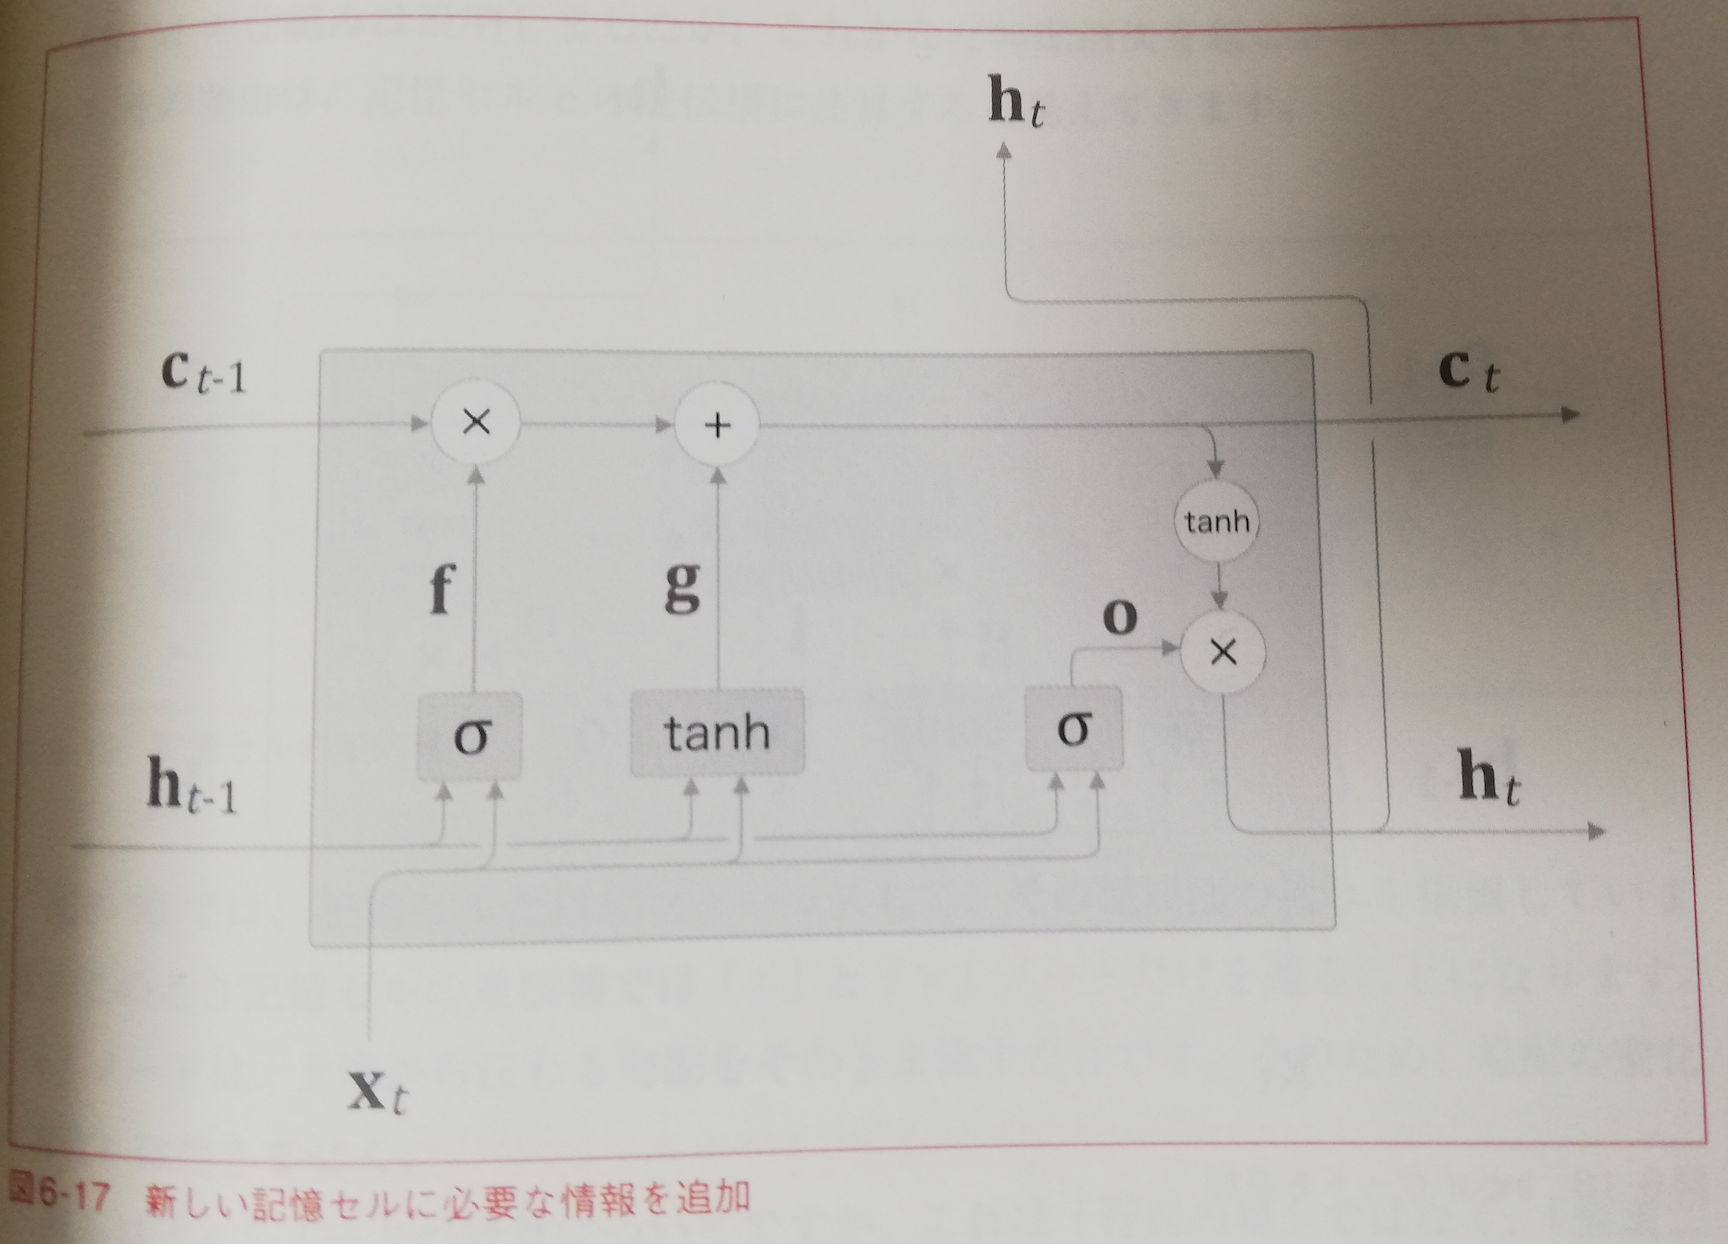

図7-17で示すように、$\tanh$ノードによって計算された結果が前時刻の記憶セル $c_{t-1}$に加算される。それによって、新しい「情報」が記憶セルに追加される。

（$\tanh$）の出力は-1.0〜1.0の実数。何らかのエンコードされた「情報」に対する強弱（度合い）が表されていると解釈できる）

そのときの、$\tanh$ノードで行う計算は次になる。

*(6.4)*
$$
  g = \tanh (x_t W^{(g)}_x + h_{t-1} W^{(g)}_h + b^{(g)}
$$



### 6.2.6 inputゲート

最後に、図6-17のgに対してゲートを加える。ここでは、新たに追加するゲートをinputゲートと呼ぶ。

![6-17](images/6-17.png)

inputゲートは、gの各要素が新たに追加する情報としてどれだけ価値があるかを判断する。図6-18では、inputゲートを「$\sigma$」で表し、その出力をiとする。

*(6.5)*
$$
  i = \sigma (x_t W^{(i)}_x + h_{t-1} W^{(i)}_h + b^{(i)})
$$


### 6.2.7 LSTMの勾配の流れ

LSTMの仕組みは説明したが、なぜこれが勾配消失を起こさないのか？その理由は、記憶セルcの逆伝播に注目すると見えてくる。

![6-19](images/6-19.png)

図6-19では、記憶セルだけにフォーカスして、その逆伝播の流れを描画している。このとき記憶セルの逆伝播では「＋」と「×」ノードだけを通ることになる。「＋」ノードは、上流から伝わる勾配をそのまま流すだけ。そのため、勾配の変化は起きない。

残るは「×」ノードの計算だが、これは「要素ごとの積（アダマール積）」。ここに勾配消失を起こさない（起こしにくい）理由がある。

図6-19の「×」ノードの計算はforgetゲートによってコントロールされる。そしてそれは、毎時刻、異なるゲート値を出力する。ここでforgetノードが「忘れるべき」と判断した記憶セルの要素に対しては、その勾配の要素は小さくなる。その一方で、forgetノードが「忘れてはいけない」と導いた要素に対しては、その勾配の要素は劣化することなく過去方向へ伝わる。そのため、記憶セルの勾配は、（長期にわたって覚えておくべき情報に対しては）勾配消失は起こさずに伝播することが期待できる。
